# ISY5002 PSUPR/PRMLS CA1
## Data set is sourced from https://archive.ics.uci.edu/ml/datasets/Dota2+Games+Results
## Data set label for column 5 onward are from https://github.com/kronusme/dota2-api/blob/master/data/heroes.json

The objectives is to predict if a game will win given the type of heroes picked by both teams from a pool of 113 possible heroes to choose from.
The "Won" column denotes the whether the team won (value of 1) or if the opposition team won (value of -1)
Column 5 onwards represent the heroes that could be picked, each team will pick 5 heroes with value of 1 representing hero picked by the team and value of -1 for heroes picked by the opposition team. Value of zero represents heroes not picked by either teams.

##### Name: Raymond Ng Boon Cheong  
##### Student ID: A0198543R

##### Import dependencies

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import LinearSVC
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

##### Read dataset from csv

In [18]:
raw_data_train = pd.read_csv('..\dataset\dota2Train.csv')
raw_data_test = pd.read_csv('..\dataset\dota2Test.csv')

In [19]:
raw_data_train.head()

,Won,Cluster ID,Game Mode,Game Type,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,...,Legion Commander,Techies,Ember Spirit,Earth Spirit,Abyssal Underlord,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
0,-1,223,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,152,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
2,1,131,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
3,1,154,2,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
4,-1,171,2,3,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0


##### Drop label columns and other non-relevent column

In [20]:
x_train = raw_data_train.drop(["Won", "Cluster ID"], axis=1)
y_train = raw_data_train["Won"]
x_test = raw_data_test.drop(["Won", "Cluster ID"], axis=1)
y_test = raw_data_test["Won"]

In [21]:
x_train.head()

,Game Mode,Game Type,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,Earthshaker,Juggernaut,...,Legion Commander,Techies,Ember Spirit,Earth Spirit,Abyssal Underlord,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
0,2,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,2,0,0,0,1,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,0,0,0,1,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,2,0,0,0,0,0,0,-1,0,...,-1,0,0,0,0,0,0,0,0,0
4,2,3,0,0,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
y_train.head()

0   -1
1    1
2    1
3    1
4   -1
Name: Won, dtype: int64

In [23]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92650 entries, 0 to 92649
Columns: 115 entries, Game Mode to Arc Warden
dtypes: int64(115)
memory usage: 81.3 MB


In [24]:
x_train.describe()

,Game Mode,Game Type,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,Earthshaker,Juggernaut,...,Legion Commander,Techies,Ember Spirit,Earth Spirit,Abyssal Underlord,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
count,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000,...,92650.000000,92650.000000,92650.000000,92650.000000,92650.0,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000
mean,3.317572,2.384587,-0.001630,-0.000971,0.000691,-0.000799,-0.002008,0.003173,-0.000345,-0.003832,...,-0.001371,-0.000950,0.000885,0.000594,0.0,0.001025,0.000648,-0.000227,-0.000043,0.000896
std,2.633070,0.486833,0.402004,0.467672,0.165052,0.355393,0.329348,0.483950,0.348865,0.501760,...,0.535024,0.206112,0.283985,0.155940,0.0,0.220703,0.204166,0.168707,0.189868,0.139033
min,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


### 1st Attempt with SVM

Build a model using linear SVC with defaults hyperparameters.  
CalibratedClassifierCV is used in conjunction with LinearSVC in order to calculate predication probability

In [43]:
cal_svc = CalibratedClassifierCV(
    base_estimator=LinearSVC(random_state=42, C=1.0, max_iter=500, verbose=False),
    method='isotonic', cv=5)
cal_svc.fit(x_train, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None,
                                                dual=True, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=500, multi_class='ovr',
                                                penalty='l2', random_state=42,
                                                tol=0.0001, verbose=False),
                       cv=5, method='isotonic')

##### Prediction and show metrics

In [44]:
y_pred = cal_svc.predict(x_test)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[2569 2223]
 [1908 3594]]
              precision    recall  f1-score   support

          -1       0.57      0.54      0.55      4792
           1       0.62      0.65      0.64      5502

    accuracy                           0.60     10294
   macro avg       0.60      0.59      0.59     10294
weighted avg       0.60      0.60      0.60     10294



In [45]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.598698270837381


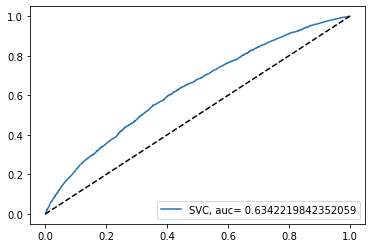

In [46]:
y_pred_proba = cal_svc.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label="SVC, auc= " + str(auc))
plt.plot([0,1],[0,1],'k--')
plt.legend(loc=4)
plt.show()

### 1st attempt summary

Using a simple SVM classifier on the dataset, it is clear the attempt does not work well as the accuracy is only 50% which is as good as random.

### 2nd attempt

As dataset have alot of zeros value or sparse data, we will try to normalize the data before training again.

In [52]:
x_train_norm = Normalizer().fit_transform(x_train)
print(x_train_norm)

[[0.47140452 0.47140452 0.         ... 0.         0.         0.        ]
 [0.47140452 0.47140452 0.         ... 0.         0.         0.        ]
 [0.47140452 0.47140452 0.         ... 0.         0.         0.        ]
 ...
 [0.41702883 0.62554324 0.         ... 0.         0.         0.        ]
 [0.47140452 0.47140452 0.         ... 0.         0.         0.        ]
 [0.47140452 0.47140452 0.         ... 0.         0.         0.        ]]


In [53]:
cal_svc_norm = CalibratedClassifierCV(
    base_estimator=LinearSVC(random_state=42, C=1.0, max_iter=500, verbose=False),
    method='isotonic', cv=5)
cal_svc_norm.fit(x_train_norm, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None,
                                                dual=True, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=500, multi_class='ovr',
                                                penalty='l2', random_state=42,
                                                tol=0.0001, verbose=False),
                       cv=5, method='isotonic')

In [54]:
y_pred = cal_svc_norm.predict(x_test)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[3121 1671]
 [2543 2959]]
              precision    recall  f1-score   support

          -1       0.55      0.65      0.60      4792
           1       0.64      0.54      0.58      5502

    accuracy                           0.59     10294
   macro avg       0.60      0.59      0.59     10294
weighted avg       0.60      0.59      0.59     10294



In [55]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.590635321546532


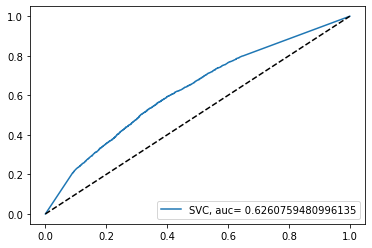

In [56]:
y_pred_proba = cal_svc_norm.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label="SVC, auc= " + str(auc))
plt.plot([0,1],[0,1],'k--')
plt.legend(loc=4)
plt.show()

### 2nd attempt summary

Results is slightly degraded with normalization preprocessing, and accuracy remains poor at 59%

### 3rd attempt

Tune the hyper parameter with grid search and normalized data

In [ ]:
params = {
    'dual': (True, False),
    'fit_intercept': (True, False),
    'C': [0.01, 0.05, 0.1, 0.5, 1.0, 5, 10, 15, 50, 100],
    'max_iter': [500, 1000, 5000, 10000, 50000],
}

In [73]:
gs = GridSearchCV(
    LinearSVC(random_state=42, verbose=False), params, cv=5, n_jobs=-1)

cal_svc_norm = CalibratedClassifierCV(
    base_estimator=gs,
    method='isotonic', cv=5)

In [ ]:
cal_svc_norm = cal_svc_norm.fit(x_train_norm, y_train)

In [ ]:
print("Best Parameters: " + cal_svc_norm.base_estimator[0].best_params_)

In [ ]:
y_pred = cal_svc_norm.base_estimator[0].predict(x_test)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

In [ ]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

In [ ]:
y_pred_proba = cal_svc_norm.base_estimator[0].predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label="SVC, auc= " + str(auc))
plt.plot([0,1],[0,1],'k--')
plt.legend(loc=4)
plt.show()

### 3rd attempt summary

### 4th attempt

SVM with ensemble model